# Fuzzy C-Means Clustering

In [125]:
# Library imports
import numpy as np
import pandas as pd
import math
from functools import reduce
import matplotlib.pyplot as plt

In [294]:
# Data imports
raw_data_csv = []
raw_data_csv.append(pd.read_csv("data/data1.csv", header=None))
raw_data_csv.append(pd.read_csv("data/data2.csv", header=None))
raw_data_csv.append(pd.read_csv("data/data3.csv", header=None))
raw_data_csv.append(pd.read_csv("data/data4.csv", header=None))

In [295]:
## Definition of constants
CONST_M = 1.4
CONST_CLUSTERING_ITERATION_NUMBER = 10

In [296]:
## Definition of general fuctions

def distance(point1, point2, to_power2=False):
    assert len(point1) == len(point2), "Points dimentions are different."
    
    dist = 0;
    for i in range(len(point1)):
        dist = dist + (point1[i] - point2[i])**2
        
    return dist if to_power2 else math.sqrt(dist)


def choose_random(data, number_of_samples):
    sample_dataframe = data.sample(n = number_of_samples)
    return sample_dataframe.iloc[:,:-1] # cut the last column

def product_with_tuple(input_scalar, input_tuple):
    return tuple([ val * input_scalar for val in input_tuple ])
    
def sum_of_tuples(tuple1, tuple2):
    return tuple([ x + y for x, y in zip(tuple1,tuple2)])
    
    
def update_cluster_values(data, centroids):
    for data_index, data_row in data.iterrows():
        point = tuple(data_row[:-1]) # cut the last column and convert to tuple
                
        distance_sum_inverse = 0
        for center_tuple in centroids:
            distance_sum_inverse = distance_sum_inverse + (1 / (distance(point,center_tuple,to_power2=True))**(1/(CONST_M-1)) )
            
        belonging_value_to_clusters = []
        for center in centroids:
            numerator = 1 / (distance(point,center,to_power2=True))**(1/(CONST_M-1))    
            belonging_value_to_clusters.append(numerator/distance_sum_inverse)
      
        data.at[data_index,'fuzzy_cluster'] = belonging_value_to_clusters
        
    
def calculate_and_get_new_centers(data, centroids):
    new_centers = []
    
    for center_index, center in enumerate(centroids):
        
        belonging_values_sum = 0
        for data_index, data_row in data.iterrows():
            belonging_values_sum = belonging_values_sum + (data_row['fuzzy_cluster'][center_index])**CONST_M
        
        share_of_each_data_in_center = []
        for data_index, data_row in data.iterrows():
            point_share_in_center = (data_row['fuzzy_cluster'][center_index]**CONST_M) / belonging_values_sum
            share_of_each_data_in_center.append(product_with_tuple(point_share_in_center, data_row[:-1]))
            
        cluster_center = reduce(lambda t1, t2: sum_of_tuples(t1, t2), share_of_each_data_in_center)
        
        new_centers.append(cluster_center)
        
    return new_centers
        
def get_cost(data, centroids):
    cost = 0
    for data_index, data_row in data.iterrows():
        for center_index, center in enumerate(centroids):
            cost = cost + ((data_row['fuzzy_cluster'][center_index]**CONST_M) * distance(data_row[:-1], center, to_power2=True) )
    return cost

def defuzzification(data):
    crisp = []
    for data_index, data_row in data.iterrows():
        crisp.append(np.array(data_row['fuzzy_cluster']).argmax())
    return crisp


In [297]:
def fuzzy_C_means(input_data, clusters_number):
    
    input_data['fuzzy_cluster'] = [[]] * len(input_data)
    random_sample_dataframe = choose_random(input_data, clusters_number)
    centroids = [ tuple(d[1]) for d in random_sample_dataframe.iterrows()]
    input_data = input_data.drop(random_sample_dataframe.index) # delete selected rows because of adding additioanl comlplexity to clculation in fuctions (0 distance to itself)
        
    for iteration in range(CONST_CLUSTERING_ITERATION_NUMBER):
        update_cluster_values(input_data, centroids)
        centroids = calculate_and_get_new_centers(input_data, centroids)

    return (input_data, centroids, get_cost(input_data, centroids))


## Cost function and elbow method

We calculate cost function for c= 1...10 and for all data files.

Then we choose best C for each dataset.

In [298]:
result = {}
for data_index, data in enumerate(raw_data_csv):
    print("processing next csv ...")
    data_result = []
    for c in range(10): 
        data_result.append(fuzzy_C_means(data, c))
    result[data_index] = data_result
    

processing next csv ...
processing next csv ...
processing next csv ...
processing next csv ...


<ipython-input-299-4d4553951f98>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


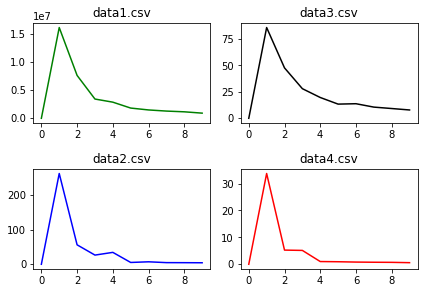

In [299]:

fig, ax = plt.subplots(2, 2)
ax[0, 0].set_title('data1.csv')
ax[0, 0].plot([result[0][i][2] for i in range(10)], 'g')
ax[1, 0].set_title('data2.csv')
ax[1, 0].plot([result[1][i][2] for i in range(10)], 'b')
ax[0, 1].set_title('data3.csv')
ax[0, 1].plot([result[2][i][2] for i in range(10)], 'k')
ax[1, 1].set_title('data4.csv')
ax[1, 1].plot([result[3][i][2] for i in range(10)], 'r')

fig.tight_layout()
fig.subplots_adjust(top=0.95)
fig.show()


### Conclusion

Based on these plots:


|data set | number of clusters
:--- | :---:
| data1.csv | 3 |
| data2.csv | 3 |
| data3.csv | 4 |
| data4.csv | 4 |




## Fuzziness Parameter

We try clustering with different values for m (Fuzziness) after that the cost function and clusters for each m will be plotted in order to analyze this parameter effect on clustering.

In [300]:
different_m_result = []
m_values = [ 1+(m/10) for m in range(1, 100, 6)]
for f in m_values:
    print("clustering with m = {}".format(f))
    CONST_M = f ## DANGER: GLOABAL VARIABLE OVERWRITING ;)
    different_m_result.append(fuzzy_C_means(raw_data_csv[0], 3))
    

clustering with m = 1.1
clustering with m = 1.7
clustering with m = 2.3
clustering with m = 2.9
clustering with m = 3.5
clustering with m = 4.1
clustering with m = 4.7
clustering with m = 5.3
clustering with m = 5.9
clustering with m = 6.5
clustering with m = 7.1
clustering with m = 7.7
clustering with m = 8.3
clustering with m = 8.9
clustering with m = 9.5
clustering with m = 10.1
clustering with m = 10.7


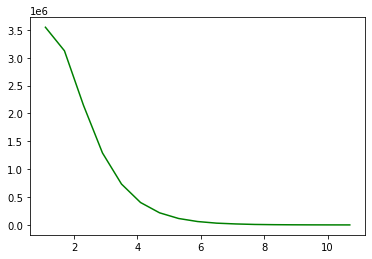

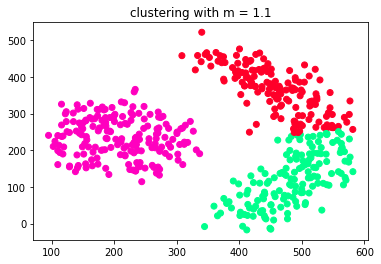

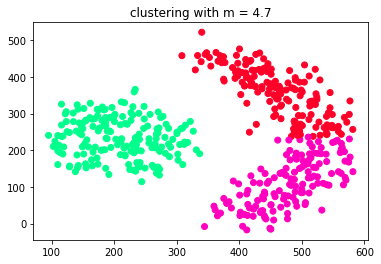

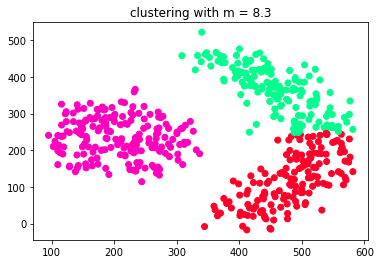

In [301]:
plt.plot(m_values,[different_m_result[i][2] for i in range(len(different_m_result))], 'g')
plt.show()

for i, m in enumerate(m_values):
    if i % 6 == 0: # because we don't want to plot all resluts
        plt.scatter(
            x=different_m_result[i][0][:][0],
            y=different_m_result[i][0][:][1],
            c=defuzzification(different_m_result[i][0]),
            cmap='gist_rainbow'
        )
        plt.gca().update(dict(title="clustering with m = {}".format(m)))
        plt.show()


### Analysis

balh blah

## Plotting Results

only for 2-D data.

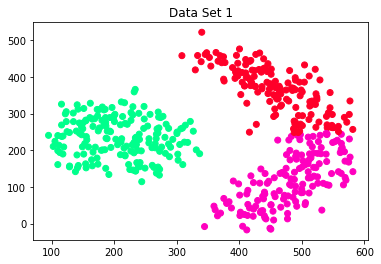

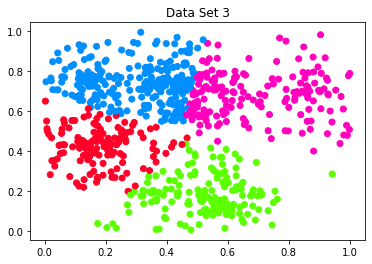

In [302]:

plt.scatter(
    x=result[0][3][0][:][0],
    y=result[0][3][0][:][1],
    c=defuzzification(result[0][3][0]),
    cmap='gist_rainbow'
)
plt.gca().update(dict(title="Data Set 1"))
plt.show()


plt.scatter(
    x=result[2][4][0][:][0],
    y=result[2][4][0][:][1],
    c=defuzzification(result[2][4][0]),
    cmap='gist_rainbow'
)
plt.gca().update(dict(title="Data Set 3"))
plt.show()

By: Ali Faraji

Thank you